# Final projection exploration notebook

Dataset: https://www.kaggle.com/datasets/crawford/cat-dataset/data, Oct 9 2024, 11:05am

"super small projects"

In [5]:
import os
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

from sklearn_col_compressor import compress_colours

from C4_preprocess_imgs import get_cropped_ROIs
from C4_helper import DataLoader, get_bbox, grabcut_algorithm, get_compressed_ROIs

all_data_dir = './cats/'
data_dir = './cats/CAT_00'
# img_ROIs_file = 'cat00_ROI_nps.npy'

img_ROIs_file = 'CAT_00_1xComp_ROIs.npy'
#'toy300range255_CAT_00_1xComp_ROIs.npy'  #use these
# '00_toy_smallsize_16cols.npy'

ImportError: cannot import name 'get_bbox' from 'C4_helper' (/Users/jsuchardt/ML2/ML2-final/C4_helper.py)

In [3]:
print(len(gold_rois))

505


# Object detection
Goal for object detection with bboxes  
Simplyfying assumption:  
No other animals than cats, 1 animal at a time  

1. Resize to half of average size in dir, to increase processing speed
2. Get bbox (if only 1 box, assume label cat), for 2+ labels, only keep if exactly one cat label is present
3. Remove background with grabCut
4. Compress colours using K-Means (k=64)


In [ ]:
if img_ROIs_file and os.path.isfile(img_ROIs_file):
    img_ROIs = np.load(img_ROIs_file)
else:
    data = DataLoader(data_dir)
    output = get_compressed_ROIs(data, verbose=True, toy=True)
    box_fail, multi_obj, col_fail, img_ROIs = output

    if img_ROIs_file:
        np.save(img_ROIs_file, img_ROIs)

print('Amount of image-ROIs from', data_dir, 'to work with:', len(img_ROIs)) #1h23h
# double comrpession, 2min30 before re-ordering in c4 hlper (box decides first) ->

Amount of image-ROIs from ./cats/CAT_00 to work with: 1585


refine to: face, body, paws, tail?

# Feature extraction/representation training

In [9]:
compressed_ROIs = [compress_colours(roi, 8) for roi in tqdm(img_ROIs)]
print('done')

100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Compress colours
https://www.geeksforgeeks.org/image-compression-using-k-means-clustering/
Oct 22, 12:52

In [10]:
# img_arrays = np.array([np.array(Image.open(imgfile).resize(data.avg_size)
#                        ).transpose(2, 0, 1).reshape(3, -1)
#               for imgfile in data.imgs[:50]], dtype=np.float32)
# img_arrays.shape
# og_img = np.array(Image.open(data.imgs[5]), dtype=np.float32)

In [14]:
# CNN example 
#https://www.kaggle.com/code/itokianarafidinarivo/6000-store-items-images-classified-by-color


In [ ]:
# # read imgs in gold imgs, save to numpy
# gold_arrs = list()

# for root, dirs, files in os.walk('./cropped/imgs'):
#     for fname in sorted(files):
#         if fname.endswith('.jpg'):
#             with Image.open('./cropped/imgs/'+fname) as f:
#                 gold_arrs.append(np.array(f))

In [60]:
# len(gold_arrs)
# np.save(config['gold_img_ROIs_file'], gold_arrs)

In [2]:
plt.imshow(compress_colours(gold_rois[82], n_colours=32))

NameError: name 'kmeans' is not defined

In [18]:
print(np.sum(gold_rois[10], axis=2))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [35]:
set([arr.shape for arr in gold_rois])

{(275, 321, 3)}

In [1]:
import argparse
import json
from train_col_compressor import train_compressor
from colour_embeddings import compress_colours
import numpy as np
import matplotlib.pyplot as plt
from C4_preprocess_imgs import gold_rois_from_imgs

parser = argparse.ArgumentParser()

parser.add_argument('-c', '--config', help='configuration file',
                    default='config.json')
args, unk = parser.parse_known_args()
config = json.load(open(args.config))

gold_rois = gold_rois_from_imgs()
gen_rois = np.load('./cropped/devroisCAT00.npy')
print(len(gold_rois), len(gen_rois))


431 1079


In [2]:
step = int(len(gold_rois)**0.5+len(gold_rois)**0.1)
bigimg = np.concatenate([np.concatenate(gold_rois[i-step:i], axis=0)
                         for i in range(step, len(gold_rois), step)],
                        axis=1)
bigimg.shape

(6050, 6099, 3)

In [3]:
colours = 65
kmeans_model = train_compressor(bigimg, colours=colours, samples=5_000, modelfile='kmeans00.pickle')

Formatting data...
Fitting model...
Model saved to kmeans00.pickle


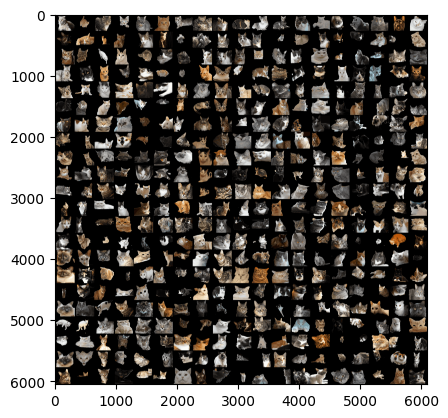

In [4]:
bigimg_comp = compress_colours(kmeans_model, bigimg)
plt.imshow(bigimg_comp/255)

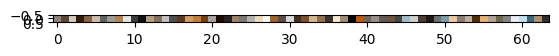

In [24]:
gold_palette = np.array([np.uint8(col) for col in kmeans_model.cluster_centers_
                         if sum(np.uint8(col)>0)])

plt.imshow((gold_palette/255).reshape(1, len(gold_palette), 3))


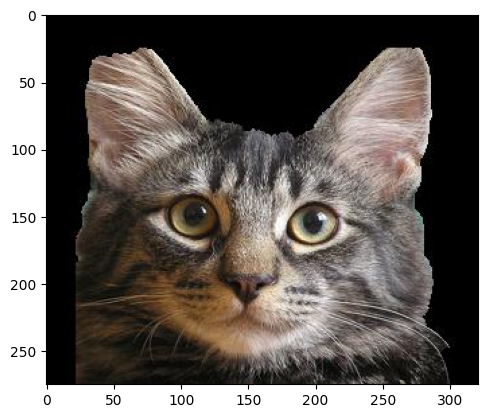

In [6]:
img = gold_rois[321]
plt.imshow(img)

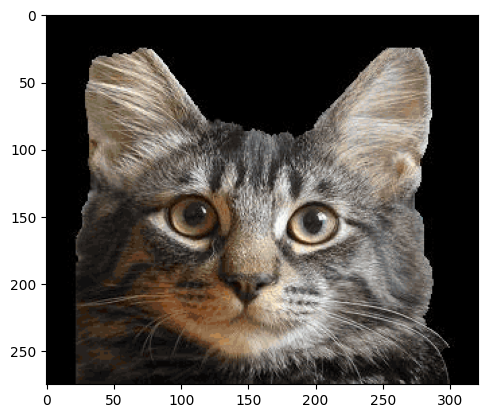

In [7]:
plt.imshow(compress_colours(kmeans_model, img)/255)

In [8]:
from colour_embeddings import get_colour_profile, plot_colour_profile


col_profile = get_colour_profile(kmeans_model, img)
print(sum(col_profile.values()))
len(col_profile), col_profile

0.9999999999999997


(64,
 {(140, 132, 123): 0.03048284691105998,
  (93, 70, 52): 0.01387471238517032,
  (214, 202, 188): 0.022974586094147362,
  (48, 29, 12): 0.01944535750739581,
  (136, 99, 65): 0.012144698372056813,
  (204, 187, 165): 0.01814784699756068,
  (97, 98, 101): 0.013061605799006972,
  (158, 154, 150): 0.026988218604570697,
  (180, 131, 80): 0.001124509108523779,
  (228, 230, 224): 0.0043769354531771705,
  (58, 59, 60): 0.01422071518779302,
  (17, 16, 16): 0.03861391277269346,
  (183, 156, 125): 0.006401051848519973,
  (129, 113, 94): 0.025863709496046917,
  (195, 193, 192): 0.02056986661591959,
  (80, 79, 80): 0.01593342906077539,
  (94, 57, 33): 0.013546009722678753,
  (211, 158, 95): 0.0,
  (195, 126, 58): 0.0,
  (117, 64, 17): 0.0006401051848519973,
  (165, 164, 162): 0.017473141532446414,
  (29, 11, 3): 0.005414943861045274,
  (39, 34, 31): 0.0583706728024497,
  (160, 128, 98): 0.005933948064979326,
  (124, 119, 115): 0.03856201235230006,
  (179, 178, 175): 0.02375309240004844,
  (239, 2

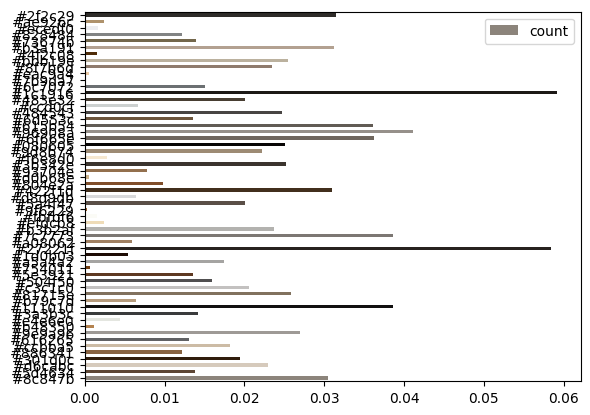

In [9]:
plot_colour_profile(col_profile)


# vectorize embedding for clustering

In [10]:
from cluster_cats import vectorize_colours
col_embedding = vectorize_colours(col_profile)
col_embedding

array([0.03048285, 0.01387471, 0.02297459, 0.01944536, 0.0121447 ,
       0.01814785, 0.01306161, 0.02698822, 0.00112451, 0.00437694,
       0.01422072, 0.03861391, 0.00640105, 0.02586371, 0.02056987,
       0.01593343, 0.01354601, 0.        , 0.        , 0.00064011,
       0.01747314, 0.00541494, 0.05837067, 0.00593395, 0.03856201,
       0.02375309, 0.00245662, 0.00152241, 0.0002768 , 0.02005086,
       0.00643565, 0.03096725, 0.00984378, 0.0005882 , 0.00780236,
       0.0252582 , 0.00281992, 0.02221338, 0.0251025 , 0.        ,
       0.03622649, 0.04113973, 0.03610539, 0.01359791, 0.0247046 ,
       0.        , 0.00671245, 0.02003356, 0.05918378, 0.01506842,
       0.0001038 , 0.0005363 , 0.02349359, 0.02541391, 0.00148781,
       0.        , 0.03119215, 0.01399581, 0.0121793 , 0.00169541,
       0.        , 0.        , 0.00242202, 0.03145165])

https://www.geeksforgeeks.org/extract-dominant-colors-of-an-image-using-python/

# Unsupervised clustering

In [ ]:
len(gen_rois[:500])

431

In [11]:
# load the gen image arrays
gen_rois = np.load('./cropped/devroisCAT00.npy')
gen_rois= gold_rois
# compress colours with the fitted method???


In [ ]:
c_profiles = [get_colour_profile(kmeans_model, roi) for roi in gen_rois[:100]]


In [52]:
list(c_profiles[0].items())[0], list(c_profiles[1].items())[0]

(((140, 132, 123), 0.02547419946971242),
 ((140, 132, 123), 0.0003226153349822562))

In [56]:
from collections import Counter
compressed_rois = [np.uint8(compress_colours(kmeans_model, img_arr)) for img_arr in gen_rois[:100]]
cc = [Counter(tuple(map(tuple, roi.reshape(roi.shape[0] * roi.shape[1], 3)))) for roi in compressed_rois]
cc_norm = [
        dict(sorted({col: count/sum(profile.values())
                        for col, count in profile.items()}.items())) for profile in c_profiles
                       if sum(profile.values())>0]

In [60]:
list(cc_norm[0].items())[0], list(cc_norm[1].items())[0]

(((8, 6, 5), 0.0458086885580257), ((8, 6, 5), 0.19274473957773236))

In [61]:
cc_norm[0]

{(8, 6, 5): 0.0458086885580257,
 (17, 16, 16): 0.01794819498266368,
 (28, 25, 22): 0.07340403834387112,
 (29, 11, 3): 0.019375892310830107,
 (39, 34, 31): 0.029675708749745056,
 (47, 44, 41): 0.020048949622679994,
 (48, 29, 12): 0.033632469916377736,
 (58, 59, 60): 0.005649602284315726,
 (59, 52, 46): 0.023658984295329394,
 (61, 100, 120): 0.0,
 (66, 47, 29): 0.010809708341831533,
 (72, 62, 50): 0.028207220069345302,
 (72, 69, 67): 0.01666326738731389,
 (79, 44, 8): 6.118702834998982e-05,
 (80, 79, 80): 0.007301652049765451,
 (90, 79, 71): 0.01970222312869672,
 (93, 70, 52): 0.004323883336732614,
 (94, 57, 33): 0.0003467264939832756,
 (97, 91, 84): 0.022292473995512953,
 (97, 98, 101): 0.006730573118498879,
 (108, 112, 114): 0.00803589638996533,
 (109, 85, 60): 0.0009993881297165003,
 (111, 102, 94): 0.023434631858046097,
 (115, 103, 75): 0.002773811951866205,
 (117, 64, 17): 0.0,
 (123, 157, 167): 0.0002855394656332858,
 (124, 119, 115): 0.024291250254945954,
 (128, 78, 42): 2.0395676

In [42]:
compressed_rois[0].flatten()                          
#.reshape(compressed_rois[0].shape[0] * compressed_rois[0].shape[1],

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [27]:
c_embeds = [vectorize_colours(roi) for roi in c_profiles]
len(c_embeds) #15s

100

### keep for commenting purposes, edited ver in cluster_cats.py

In [ ]:
# from sklearn.cluster import KMeans

# def get_ccluster(ROI_input, n=2, is_pal=False):
#     # oct 21, 16:32
#     #https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb
#     # ROI_matrix = np.array([np.uint8(img_arr*255).flatten() for img_arr in ROI_list],
#     #                       dtype=np.float32)
#     # ROI_palettes = [np.array(list(set([tuple(a) for b in img_arr for a in b])))
#     #              for img_arr in ROI_list]

#             # ROI_palettes = [np.array(list([tuple(a) for b in img_arr for a in b]))
#             #             for img_arr in ROI_list]

#     if is_pal:
#         ROI_palettes = [np.array(list(set([tuple(a) for b in img_arr
#                                         for a in b])))
#                         for img_arr in img_ROIs]
#         ROI_list = [arr.reshape(1, 64, 3) for arr in ROI_palettes
#                         if arr.shape==(64, 3)]
#     else:
#         ROI_list=ROI_input

#     # ROI_feats = list()
#     # for img in ROI_list:
#     # # print(img.shape)
#     #     r_vals, g_vals, b_vals = list(), list(), list()
#     #     for a in img:
#     #         for col in a:
#     #             if col.any():
#     #                 r_vals.append(col[0])
#     #                 g_vals.append(col[1])
#     #                 b_vals.append(col[2])
#     #     img_feats = np.array([max(r_vals), min(r_vals), sum(r_vals)/len(r_vals),
#     #                     max(g_vals), min(g_vals), sum(g_vals)/len(g_vals),
#     #                     max(b_vals), min(b_vals), sum(b_vals)/len(b_vals)])
            
#     #     #print(img_feats.shape)
#     #     ROI_feats.append(img_feats)
#     # else:
#     #     ROI_palettes = [np.array(list(set([tuple(a) for b in img_arr for a in b])))
#     #              for img_arr in ROI_list]

#     #     for img in ROI_palettes:
#     #         #print(img.shape)

#     #         r_vals, g_vals, b_vals = list(), list(), list()

#     #         for col in img:
#     #             if col.any():
#     #                 r_vals.append(col[0])
#     #                 g_vals.append(col[1])
#     #                 b_vals.append(col[2])

            
#         #  print(len(img))
#         # print(max(r_vals), min(r_vals), sum(r_vals)/64, sum(r_vals)/len(r_vals))
#         # print(max(g_vals), min(g_vals), sum(g_vals)/64, sum(g_vals)/len(g_vals))
#         # print(max(b_vals), min(b_vals), sum(b_vals)/64, sum(b_vals)/len(b_vals))
#         # img_feats = np.array([max(r_vals), min(r_vals), sum(r_vals)/len(r_vals),
#         #                     max(g_vals), min(g_vals), sum(g_vals)/len(g_vals),
#         #                     max(b_vals), min(b_vals), sum(b_vals)/len(b_vals)])
                
#         #     #print(img_feats.shape)
#         # ROI_feats.append(img_feats)

#     #ROI_feats = np.array([arr.flatten() for arr in ROI_list])

#     # # normalise values
#     # ROI_mat /= 255
#     # #flat_ROIs = KMeans.fit_transform(flat_ROIs) ??

#     kmeans = KMeans(n_clusters=n, init='k-means++', random_state=0)
#     Y = kmeans.fit_predict(ROI_input) #2mins for n=5, 50sec for n=2

#     # clusters_dict = {cluster_id : list() for cluster_id in set(Y)}
#     # for i, cluster_id in enumerate(Y):
#     #     clusters_dict[cluster_id].append(ROI_input[i])

#     return Y

In [17]:
from cluster_cats import get_ccluster, vis_cluster

Y = get_ccluster(c_embeds, n=4)
[('cluster nr: '+ str(id), 'items in cluster: '+ str(list(Y).count(id))) for id in set(Y)]


[('cluster nr: 0', 'items in cluster: 17'),
 ('cluster nr: 1', 'items in cluster: 35'),
 ('cluster nr: 2', 'items in cluster: 29'),
 ('cluster nr: 3', 'items in cluster: 19')]

In [18]:
# sort rois based on cluster nr
#clustered_imgs = {{'cluster_id': id, 'img': gen_rois[i]} for i, id in enumerate(Y)}
# include this somewhere else? problem: needs og igms
clustered_imgs =  {id: [] for id in set(Y)}
for i, id in enumerate(Y):
    clustered_imgs[id].append(gen_rois[i])
len(clustered_imgs[0])

17

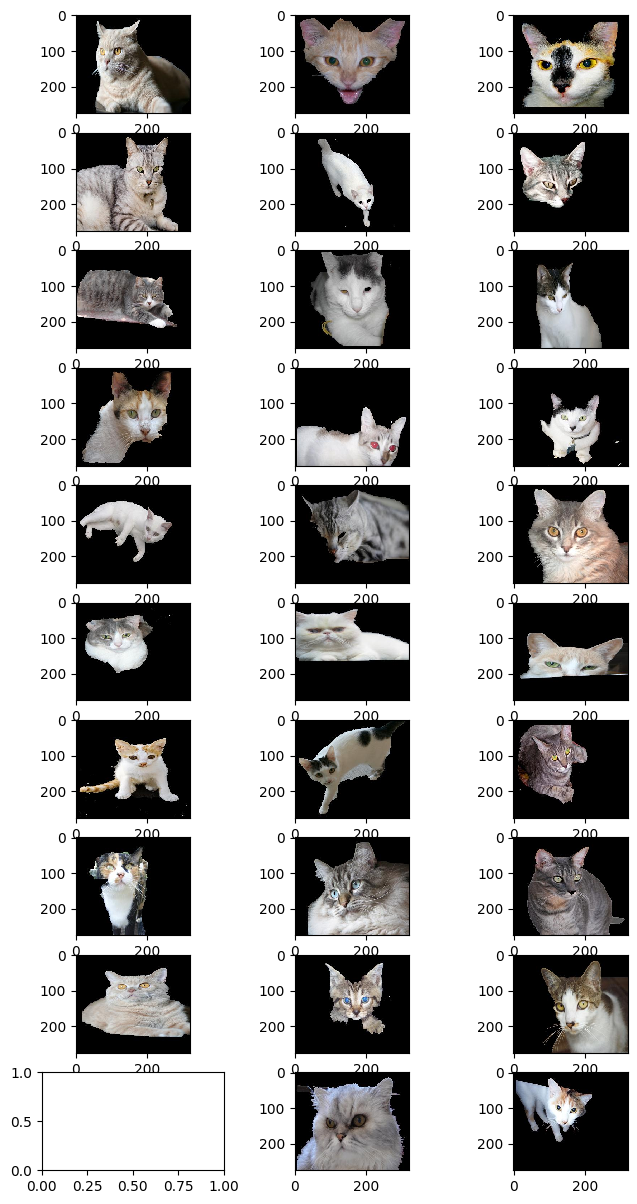

In [21]:
vis_cluster(clustered_imgs[2])

In [22]:
# ?? use ggplot in r 
# on clustering https://www.geeksforgeeks.org/clustering-in-machine-learning/

# project https://www.trpkovski.com/2023/10/23/grouping-images-by-colours-exploring-colour-based-image-clustering

In [23]:
# features: max pooling for darkest & lightest areas, also mean colour
# normalise with cnn first to reduce noise, also adjust for lighting
# later adapt if u use different region?

In [24]:
# code example?
# https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb
